In [144]:
import h5py
import matplotlib.pyplot as plt

import tifffile
from skimage import io
from PIL import Image
import cv2
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import os

from glob import glob
import os.path as osp
import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split

### Dataset images

In [5]:
BASE_PATH='archive/'
IMAGES_PATH = osp.join(BASE_PATH, 'Images')
LABELS_PATH = osp.join(BASE_PATH, 'Masks')

In [6]:
imgs_paths = glob(osp.join(IMAGES_PATH,"*.tif"))

In [30]:
masks_paths = [osp.join(LABELS_PATH, i.split("\\")[-1].split("_ccd")[0]+".TIF") for i in imgs_paths]

In [69]:
img_mask_tuples = list(zip(imgs_paths, masks_paths))

In [146]:
def get_tiff_image(path, normalized=True, resize=(512, 512)):
    image = io.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if normalized:
        return image/255
    return image

In [147]:
class BCDataset():
    
    def __init__(self, img_mask_tuples):
        self.img_mask_tuples = img_mask_tuples
        
    def __len__(self):
        return len(self.img_mask_tuples)
    
    def __getitem__(self, idx):
        
        img_path, mask_path = self.img_mask_tuples[idx]
        
        image = get_tiff_image(img_path)
        mask = get_tiff_image(mask_path)
        
        return image, mask, img_path
    
    def save_images_as_jpeg(self, output_dir):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        for idx in range(len(self)):
            image, _, img_path = self[idx]
            img_name = os.path.basename(img_path)
            img_name_no_ext = os.path.splitext(img_name)[0]
            img_save_path = os.path.join(output_dir, f'{img_name_no_ext}.jpg')
            
            image_pil = Image.fromarray((image * 255).astype(np.uint8))
            image_pil.save(img_save_path, 'JPEG')
            print(f"Saved {img_save_path}")

In [61]:
train_dataset = BCDataset(img_mask_tuples)

(768, 896, 3)


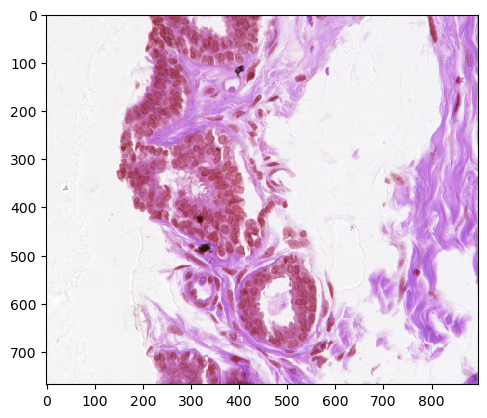

In [62]:
fotka = train_dataset.__getitem__(2)
print(fotka[0].shape)
plt.imshow(fotka[0], interpolation='nearest')
plt.show()

(768, 896, 3)


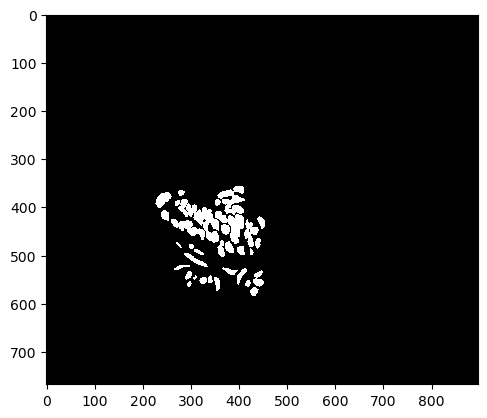

In [45]:
fotka = train_dataset.__getitem__(2)
print(fotka[0].shape)
plt.imshow(fotka[1], interpolation='nearest')
plt.show()

(768, 896, 3)


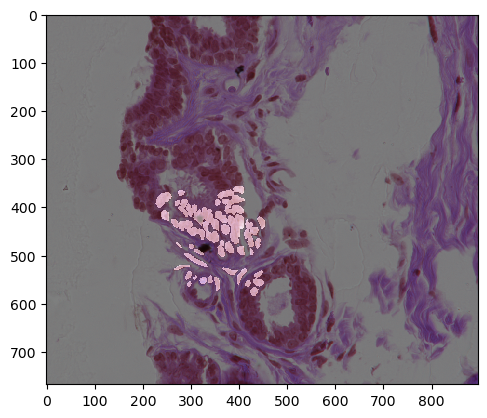

In [46]:
krotka = train_dataset.__getitem__(2)
fotka = krotka[0]
maska = krotka[1]
print(fotka.shape)
fotka = fotka / 2
fotka = fotka + maska / 2
plt.imshow(fotka, interpolation='nearest')
plt.show()

In [145]:
train_dataset.save_images_as_jpeg('output_directory')

Saved output_directory\ytma10_010704_benign1_ccd.jpg
Saved output_directory\ytma10_010704_benign2_ccd.jpg
Saved output_directory\ytma10_010704_benign3_ccd.jpg
Saved output_directory\ytma10_010704_malignant1_ccd.jpg
Saved output_directory\ytma10_010704_malignant2_ccd.jpg
Saved output_directory\ytma10_010704_malignant3_ccd.jpg
Saved output_directory\ytma12_010804_benign1_ccd.jpg
Saved output_directory\ytma12_010804_benign2_ccd.jpg
Saved output_directory\ytma12_010804_benign3_ccd.jpg
Saved output_directory\ytma12_010804_malignant1_ccd.jpg
Saved output_directory\ytma12_010804_malignant2_ccd.jpg
Saved output_directory\ytma12_010804_malignant3_ccd.jpg
Saved output_directory\ytma23_022103_benign1_ccd.jpg
Saved output_directory\ytma23_022103_benign2_ccd.jpg
Saved output_directory\ytma23_022103_benign3_ccd.jpg
Saved output_directory\ytma23_022103_malignant1_ccd.jpg
Saved output_directory\ytma23_022103_malignant2_ccd.jpg
Saved output_directory\ytma23_022103_malignant3_ccd.jpg
Saved output_direct

### Preprocessing output

In [23]:
file_path2 = "CLAM/FEATURES_DIRECTORY_64/h5_files/ytma49_111303_benign2_ccd.h5"
with h5py.File(file_path2, 'r') as f2:
    print("Features:", f2['features'][1])
    print("Dim:", len(f2['features'][1]))

Features: [0.09713714 0.00680048 0.01560309 ... 0.01563466 0.03020944 0.04003365]
Dim: 1024


In [14]:
file_path = "CLAM/RESULTS_DIRECTORY_64/patches/ytma49_111303_benign2_ccd.h5"
with h5py.File(file_path, 'r') as f:
    print(len(f['coords'][:]))

146


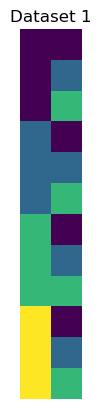

In [8]:
# Open the H5 file in read mode
file_path = "CLAM/RESULTS_DIRECTORY_32/patches/ytma10_010704_benign1_ccd.h5"
with h5py.File(file_path, 'r') as f:
    # Get the keys (dataset names)
    dataset_names = list(f.keys())
    
    # Plot the first 5 datasets (assuming they contain images)
    for i, dataset_name in enumerate(dataset_names):
        dataset = f[dataset_name]
        image_data = dataset[:]  # Read the image data
        
        # Plot the image
        plt.subplot(1, 5, i+1)
        plt.imshow(image_data)  # Assuming grayscale images, adjust colormap if necessary
        plt.title(f'Dataset {i+1}')
        plt.axis('off')

# Show the plot
plt.show()

### Annotation visualization

In [64]:
HEATMAP_PATH = "Visualization/out/out1/"

In [65]:
imgs_paths_annt = glob(osp.join(HEATMAP_PATH,"*.jpg"))

In [66]:
masks_paths_annt = [osp.join(LABELS_PATH, i.split("\\")[-1].split("_ccd")[0]+".TIF") for i in imgs_paths_annt]

In [119]:
img_mask_tuples_annt = list(zip(imgs_paths_annt, masks_paths_annt))[2:]

In [148]:
def get_image(path, normalized=True, resize=(512, 512)):
    image = io.imread(path)
    if normalized:
        return image / 255
    return image
    
def add_mask(image, mask):
    image = image / 2
    image = image + mask / 2
    return image

def show_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.show()
    
class ANNTDataset():
    
    def __init__(self, img_mask_tuples):
        self.img_mask_tuples = img_mask_tuples
        
    def __len__(self):
        return len(self.img_mask_tuples)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.img_mask_tuples[idx]
        
        image = get_image(img_path)
        mask = get_tiff_image(mask_path)
        
        return image, mask, img_path

    def save_images_as_jpeg(self, output_dir, use_mask=True):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        for idx in range(len(self)):
            image, mask, img_path = self[idx]
            img_name = os.path.basename(img_path)
            img_name_no_ext = os.path.splitext(img_name)[0]
            img_save_path = os.path.join(output_dir, f'{img_name_no_ext}.jpg')

            if use_mask:
                image = add_mask(image, mask)
            
            image_pil = Image.fromarray((image * 255).astype(np.uint8))
            image_pil.save(img_save_path, 'JPEG')
            print(f"Saved {img_save_path}")

In [140]:
annotation_dataset = ANNTDataset(img_mask_tuples_annt)

(768, 896, 3)


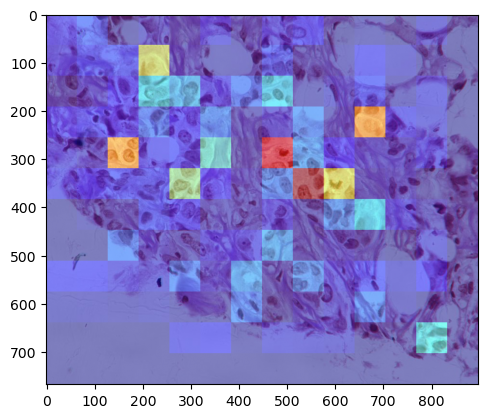

In [141]:
fotka = annotation_dataset.__getitem__(3)
print(fotka[0].shape)
plt.imshow(fotka[0])
plt.show()

0: Visualization/out/out1\ytma10_010704_malignant1_ccd.jpg


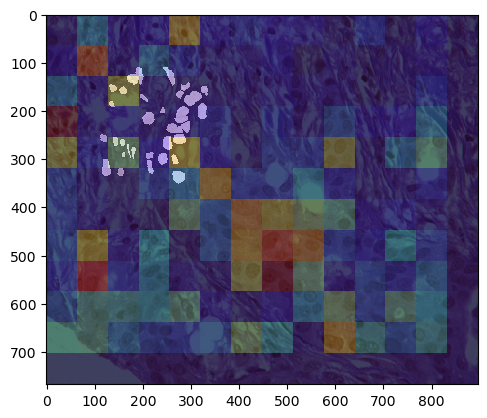

1: Visualization/out/out1\ytma10_010704_malignant2_ccd.jpg


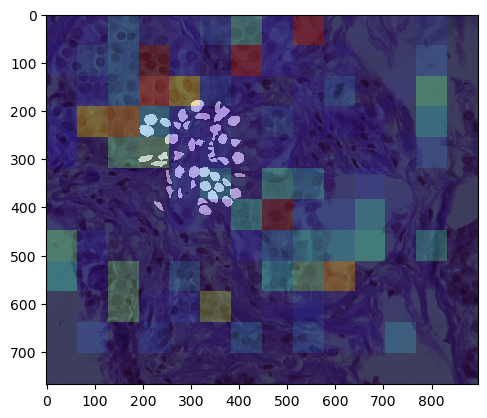

2: Visualization/out/out1\ytma10_010704_malignant3_ccd.jpg


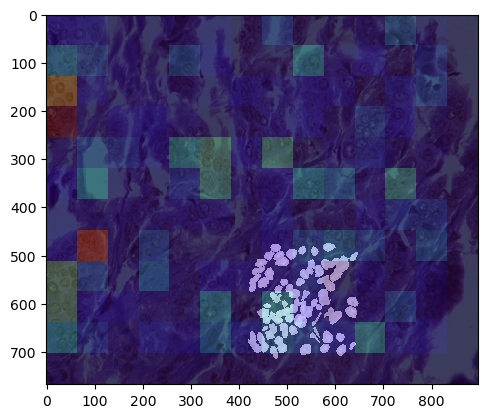

3: Visualization/out/out1\ytma12_010804_malignant1_ccd.jpg


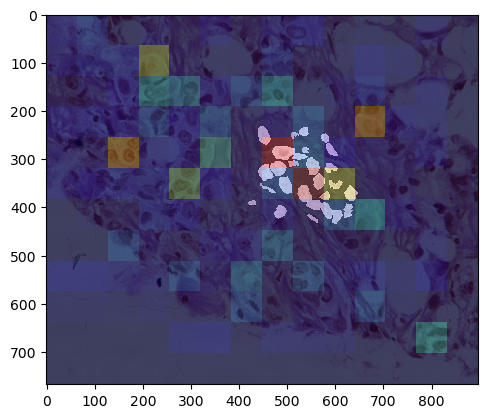

4: Visualization/out/out1\ytma12_010804_malignant2_ccd.jpg


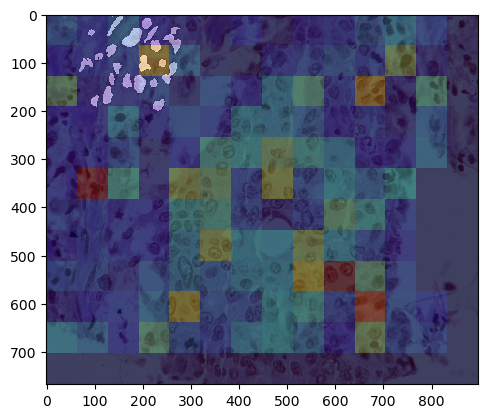

5: Visualization/out/out1\ytma12_010804_malignant3_ccd.jpg


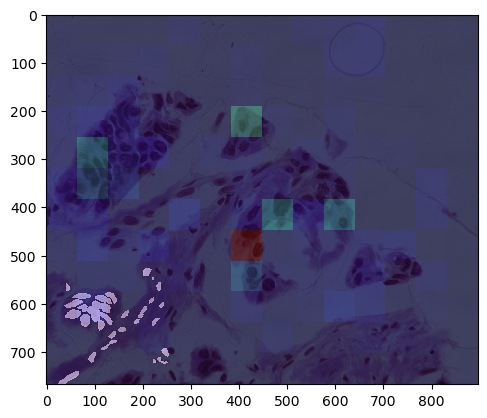

6: Visualization/out/out1\ytma23_022103_malignant1_ccd.jpg


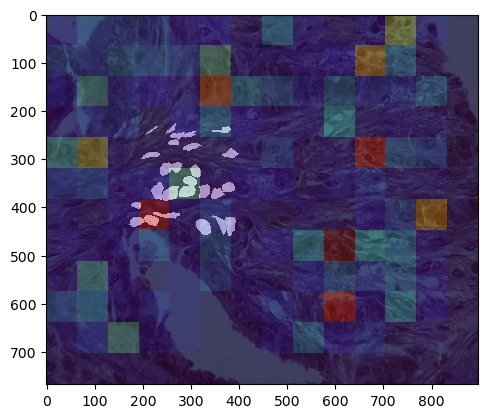

7: Visualization/out/out1\ytma23_022103_malignant2_ccd.jpg


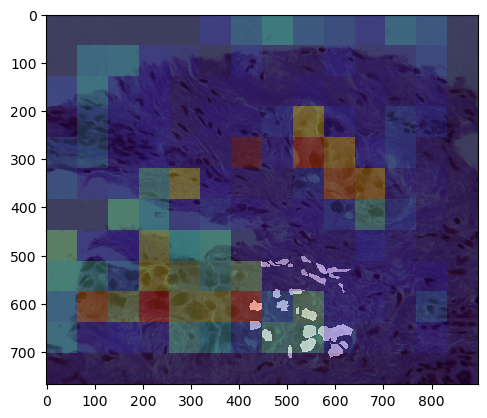

8: Visualization/out/out1\ytma23_022103_malignant3_ccd.jpg


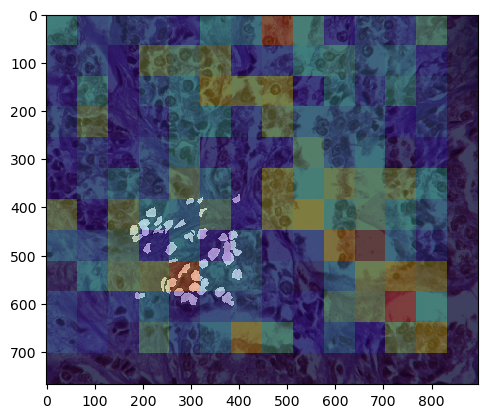

9: Visualization/out/out1\ytma49_042003_malignant1_ccd.jpg


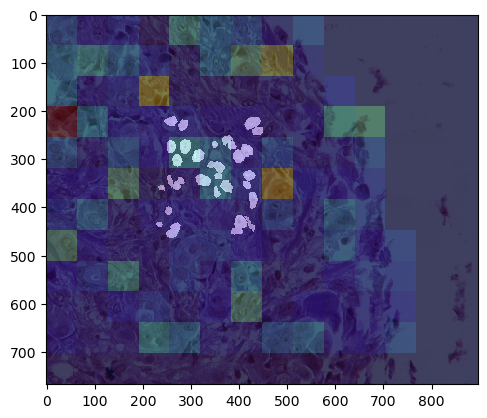

10: Visualization/out/out1\ytma49_042003_malignant2_ccd.jpg


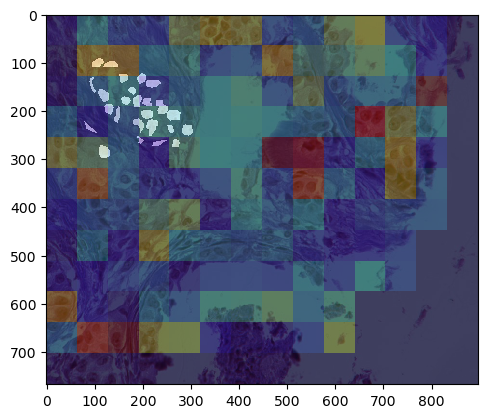

11: Visualization/out/out1\ytma49_042003_malignant3_ccd.jpg


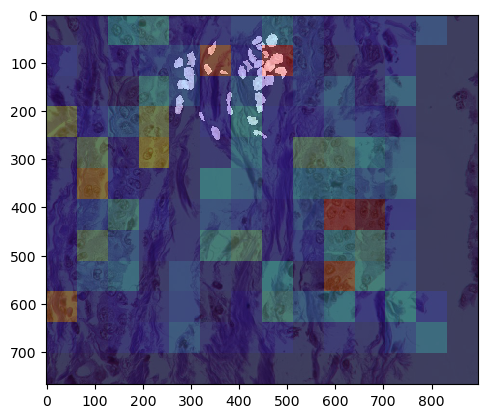

12: Visualization/out/out1\ytma49_042203_malignant1_ccd.jpg


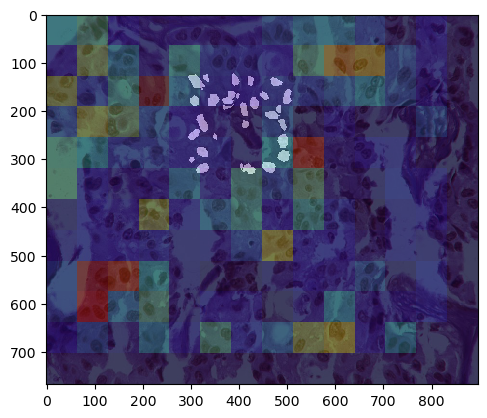

13: Visualization/out/out1\ytma49_042203_malignant2_ccd.jpg


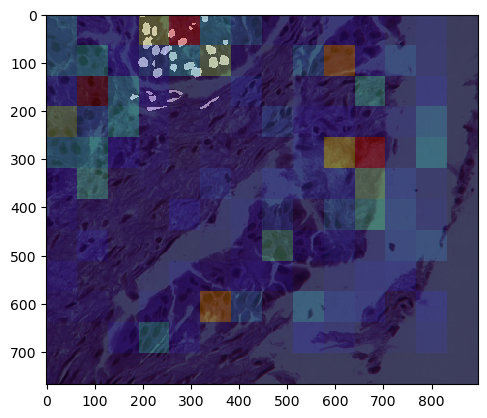

14: Visualization/out/out1\ytma49_042203_malignant3_ccd.jpg


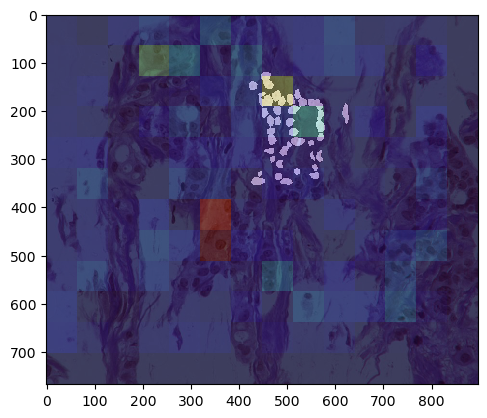

15: Visualization/out/out1\ytma49_042403_malignant1_ccd.jpg


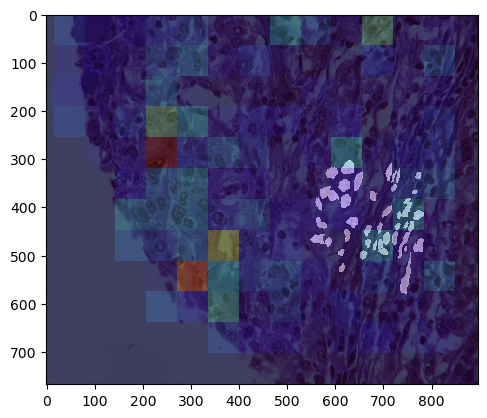

16: Visualization/out/out1\ytma49_042403_malignant2_ccd.jpg


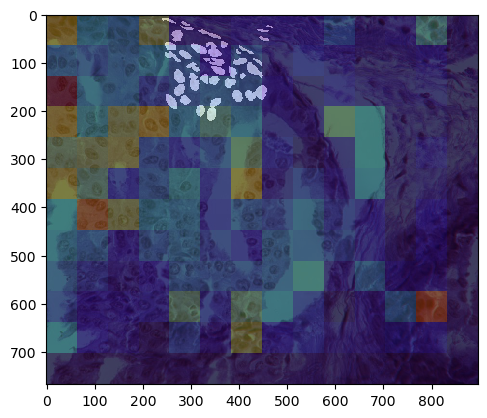

17: Visualization/out/out1\ytma49_042403_malignant3_ccd.jpg


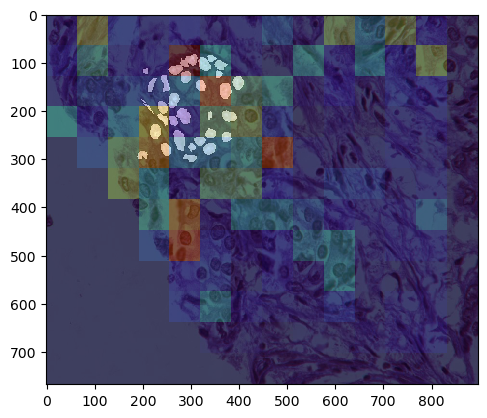

18: Visualization/out/out1\ytma49_072303_malignant1_ccd.jpg


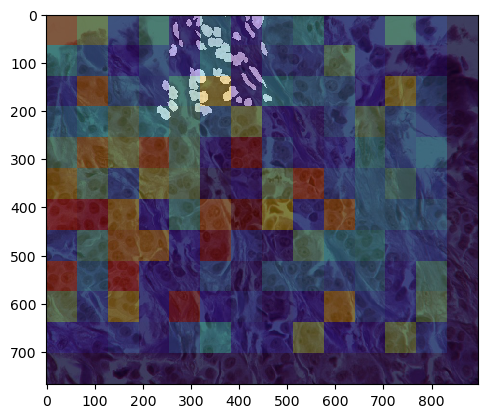

19: Visualization/out/out1\ytma49_072303_malignant2_ccd.jpg


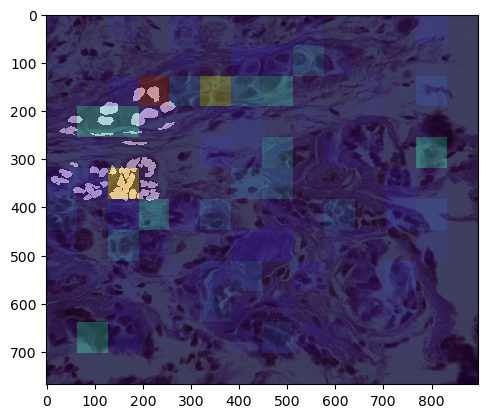

20: Visualization/out/out1\ytma49_111003_malignant1_ccd.jpg


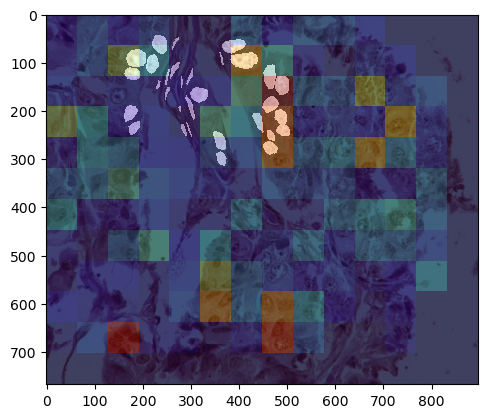

21: Visualization/out/out1\ytma49_111003_malignant2_ccd.jpg


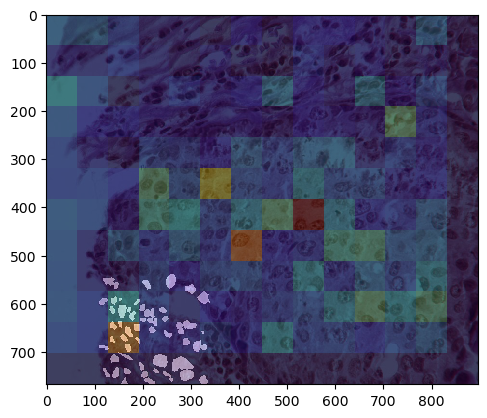

22: Visualization/out/out1\ytma49_111003_malignant3_ccd.jpg


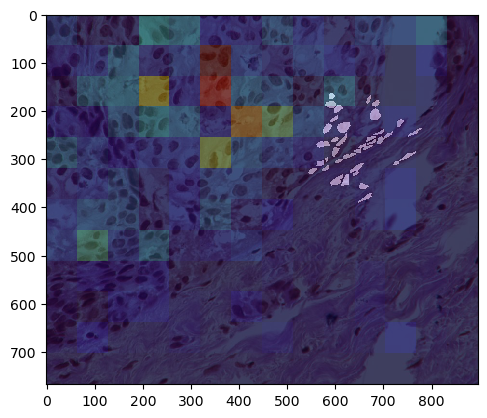

23: Visualization/out/out1\ytma49_111303_malignant1_ccd.jpg


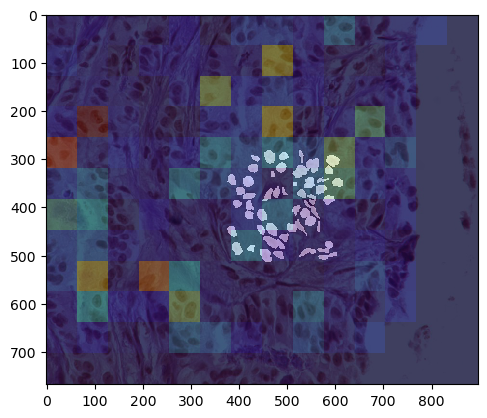

24: Visualization/out/out1\ytma49_111303_malignant3_ccd.jpg


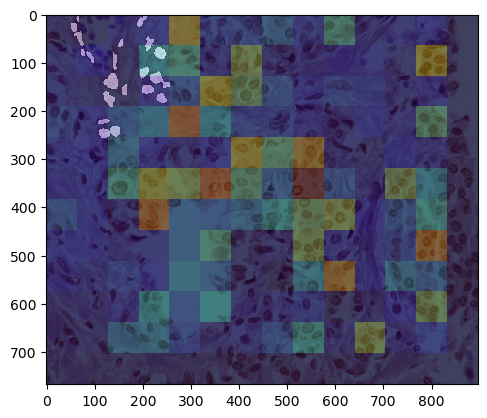

In [125]:
for i, file in enumerate(annotation_dataset):
    print(f"{i}: {file[2]}")
    image = add_mask(file[0], file[1])
    show_image(image)

In [142]:
annotation_dataset.save_images_as_jpeg("Visualization/out/masks")

Saved Visualization/out/masks\ytma10_010704_malignant1_ccd.jpg
Saved Visualization/out/masks\ytma10_010704_malignant2_ccd.jpg
Saved Visualization/out/masks\ytma10_010704_malignant3_ccd.jpg
Saved Visualization/out/masks\ytma12_010804_malignant1_ccd.jpg
Saved Visualization/out/masks\ytma12_010804_malignant2_ccd.jpg
Saved Visualization/out/masks\ytma12_010804_malignant3_ccd.jpg
Saved Visualization/out/masks\ytma23_022103_malignant1_ccd.jpg
Saved Visualization/out/masks\ytma23_022103_malignant2_ccd.jpg
Saved Visualization/out/masks\ytma23_022103_malignant3_ccd.jpg
Saved Visualization/out/masks\ytma49_042003_malignant1_ccd.jpg
Saved Visualization/out/masks\ytma49_042003_malignant2_ccd.jpg
Saved Visualization/out/masks\ytma49_042003_malignant3_ccd.jpg
Saved Visualization/out/masks\ytma49_042203_malignant1_ccd.jpg
Saved Visualization/out/masks\ytma49_042203_malignant2_ccd.jpg
Saved Visualization/out/masks\ytma49_042203_malignant3_ccd.jpg
Saved Visualization/out/masks\ytma49_042403_malignant1_